In [5]:
using JuMP
using Gurobi
using Plots
pyplot()
using MLDataPattern

INFO: Precompiling module MLDataPattern.


In [3]:
using Polyhedra, CDDLib

INFO: Precompiling module Polyhedra.
  likely near /home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/GeometryTypes/src/typealias.jl:90
INFO: Precompiling module CDDLib.


In [6]:
include("piecewise.jl")
include("mpc.jl")
# include("learning.jl")

function JuMP.solve(mm::MPC.MPCModel, x0::Vector)
    JuMP.fix.(mm.x[:, 1], x0)
    status = solve(mm.model; suppress_warnings=true)
    utraj = pf.PiecewiseFunction(mm.times, [t -> getvalue.(mm.u[:, j]) for j in 1:size(mm.u, 2)])
    status, utraj
end

function MPC.output(controller::PiecewiseFunctions.PiecewiseFunction, t, state) 
    controller(t)
end

In [7]:
mass = 1.
l = 1.
g = 10.
N = 4
A = [0. 1.;
     g/l 0.]
B = [0 1/(mass*l^2.)]'
Δt = .1
sys = MPC.discretize(MPC.CTLinearSytstem(A, B), Δt)

x_max = [pi/6, pi/20/(N*Δt)]
x_min = -x_max
u_max = [mass*g*l*pi/8.]
u_min = -u_max
times = 0:Δt:N*Δt

0.0:0.1:0.4

In [8]:
x0 = [0.1, 0.05]
mm = MPC.MPCModel(sys, N)
setsolver(mm.model, GurobiSolver(OutputFlag=0))
setlowerbound.(mm.u, u_min)
setupperbound.(mm.u, u_max)
setlowerbound.(mm.x[:, 2:end], x_min)
setupperbound.(mm.x[:, 2:end], x_max)
status, utraj = solve(mm, x0)
states = MPC.simulate(sys, utraj, x0, times)
for i in 1:length(states)
    @assert states[i] ≈ getvalue.(mm.x[:, i])
end

In [10]:
mm = MPC.MPCModel(sys, N)
setsolver(mm.model, GurobiSolver(OutputFlag=0))
setlowerbound.(mm.u, u_min)
setupperbound.(mm.u, u_max)
setlowerbound.(mm.x[:, 2:end], x_min)
setupperbound.(mm.x[:, 2:end], x_max)


num_samples = 10000
X = fill(NaN, 2, num_samples)
U = fill(NaN, 1, num_samples)

for i in 1:num_samples
    while true
        x0 = x_min .+ rand(2) .* (x_max .- x_min)
        status, utraj = solve(mm, x0)
        if status == :Optimal
            X[:, i] = x0
            U[:, i] = getvalue.(mm.u[:, 1])
#             push!(samples, Learning.Sample{2, 1}(x0, getvalue.(mm.u[:, 1])))
            break
        end
    end
end

  0.396303 seconds (138.51 k allocations: 9.586 MB, 1.61% gc time)


In [148]:
using MXNet

(X_train, U_train), (X_test, U_test) = splitobs((X, U), 0.6)
batch_size = 100
train_provider = mx.ArrayDataProvider(:x=>collect(X_train), :u_label=>collect(U_train), batch_size=batch_size)
test_provider = mx.ArrayDataProvider(:x=>collect(X_test), :u_label=>collect(U_test), batch_size=batch_size)

MXNet.mx.ArrayDataProvider(Array[
Float32[-0.230354 -0.295034 … -0.296223 -0.254258; 0.203055 0.298803 … 0.174005 -0.346689]],Symbol[:x],Array[
Float32[0.998874 1.3609 … 1.96434 3.89192]],Symbol[:u_label],100,4000,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(2,100)],MXNet.mx.NDArray[mx.NDArray{Float32}(1,100)])

In [166]:
mlp = @mx.chain mx.Variable(:x) => 
mx.FullyConnected(name=:fc1, num_hidden=4) =>
mx.Activation(name=:relu1, act_type=:relu) =>
mx.FullyConnected(name=:fc2, num_hidden=4) =>
mx.Activation(name=:relu2, act_type=:relu) => 
mx.FullyConnected(name=:fc3, num_hidden=4) => 
mx.Activation(name=:relu3, act_type=:relu) =>
mx.FullyConnected(name=:fc4, num_hidden=1) =>
mx.LinearRegressionOutput(name=:u)

# mlp = @mx.chain mx.Variable(:x) => 
# mx.FullyConnected(name=:fc1, num_hidden=1) =>|
# mx.Activation(name=:relu1, act_type=:relu) =>
# mx.FullyConnected(name=:fc2, num_hidden=1) =>
# mx.LinearRegressionOutput(name=:u)

model = mx.FeedForward(mlp, context=mx.cpu())
optimizer = mx.ADAM(lr=0.2)

mx.fit(model, optimizer, train_provider, n_epoch=30, verbosity=2)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 0 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/030 ==========
INFO: == Epoch 002/030 ==========
INFO: == Epoch 003/030 ==========
INFO: == Epoch 004/030 ==========
INFO: == Epoch 005/030 ==========
INFO: == Epoch 006/030 ==========
INFO: == Epoch 007/030 ==========
INFO: == Epoch 008/030 ==========
INFO: == Epoch 009/030 ==========
INFO: == Epoch 010/030 ==========
INFO: == Epoch 011/030 ==========
INFO: == Epoch 012/030 ==========
INFO: == Epoch 013/030 ==========
INFO: == Epoch 014/030 ==========
INFO: == Epoch 015/030 ==========
INFO: == Epoch 016/030 ==========
INFO: == Epoch 017/030 ==========
INFO: == Epoch 018/030 ==========
INFO: == Epoch 019/030 ==========
INFO: == Epoch 020/030 ==========
INFO: == Epoch 021/030 ==========
INFO: == Epoch 022/030 ==========
INFO: == Epoch 023/030 ==========
INFO: == Epoch 024/030 ==========
INFO: ==

In [167]:
U_predict = mx.predict(model, test_provider)

U_test

err = U_predict .- U_test
sqrt(mean(err.^2))

INFO: TempSpace: Total 0 MB allocated on CPU0


1×4000 Array{Float32,2}:
 1.00343  1.35111  -2.71349  2.18958  …  4.05544  1.30027  1.84852  3.40218

In [181]:
include("explicit_network.jl")

ExNet

In [182]:
net = ExNet.Net([
    Array{Float64}(model.arg_params[:fc1_weight]),
    Array{Float64}(model.arg_params[:fc2_weight]),
    Array{Float64}(model.arg_params[:fc3_weight]),
    Array{Float64}(model.arg_params[:fc4_weight]),
    ],
[
    Array{Float64}(model.arg_params[:fc1_bias]),
    Array{Float64}(model.arg_params[:fc2_bias]),
    Array{Float64}(model.arg_params[:fc3_bias]),
    Array{Float64}(model.arg_params[:fc4_bias]),
])

for i in 1:100
    x = randn(2)
    p = mx.predict(model, mx.ArrayDataProvider(:x=>reshape(x, 2, 1)), verbosity=0)[1]
    f = ExNet.feedforward(net, x)[end]
    @assert p ≈ f
end

In [183]:
bounds = hrep(polyhedron(SimpleVRepresentation([x_min[1] x_min[2]; x_min[1] x_max[2]; x_max[1] x_max[2]; x_max[1] x_min[2]]), CDDLibrary()))
results = ExNet.explore(net, bounds, [0.2, 0])

Dict{BitArray{1},Polyhedra.SimpleHRepresentation{2,Float64}} with 6 entries:
  Bool[false,false,true,fa… => H-representation…
  Bool[true,false,true,fal… => H-representation…
  Bool[true,false,true,fal… => H-representation…
  Bool[true,false,true,fal… => H-representation…
  Bool[true,false,true,fal… => H-representation…
  Bool[false,true,true,fal… => H-representation…


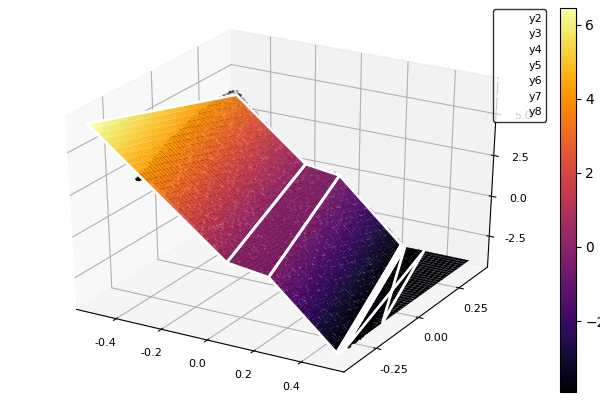

In [185]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
# zz = mx.predict(model, mx.ArrayDataProvider(:x=>hcat([[x, y] for y in yy for x in xx]...)), verbosity=0)[1, :]
plt = surface(xx, yy, (x, y) -> mx.predict(model, mx.ArrayDataProvider(:x=>[x y]'), verbosity=0)[1])
plot!(plt, [X[1, i] for i in 1:num_samples], [X[2, i] for i in 1:num_samples], [U[1, i] for i in 1:num_samples], marker=:dot, markersize=1, line=nothing)
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary(:exact)))).V
    if !isempty(V)
        x = V[[1:end; 1], 1]
        y = V[[1:end; 1], 2]
        plot!(plt, x, y, [ExNet.feedforward(net, [x[i], y[i]])[end] for i in eachindex(x)], linecolor=:white, linewidth=2)
    end
end
plt